In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import multiprocessing as mp
from tqdm import tqdm
import time

# For Perceptron
# from sklearn.linear_model import Perceptron
# from sklearn.metrics import accuracy_score
# For XGBoost
import xgboost as xgb
import torch
from torch.nn.functional import softmax
# For feature extraction: discrete wavelet transform
# import pywt

### Reading Images

In [6]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

In [7]:
print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

# cpus:  64


In [8]:
def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

100%|██████████| 450/450 [00:00<00:00, 156998.57it/s]


In [9]:
# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (64, 64))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))

100%|██████████| 450/450 [00:00<00:00, 970.68it/s] 


### Feature Extraction

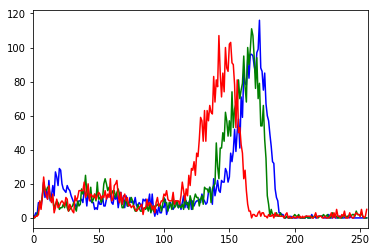

In [10]:
# color histogram
# method: opencv
color = ('b','g','r')
# plt.figure(figsize=(10, 8))
for i,col in enumerate(color):
    histr = cv2.calcHist(images=[resized_train_imgs[0]], channels=[i], mask=None, histSize=[256], ranges=[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0, 256])
plt.show();

b: 


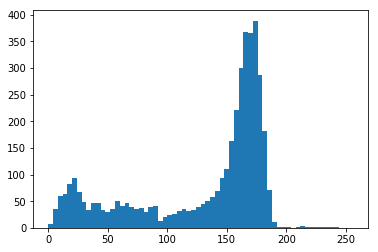

g: 


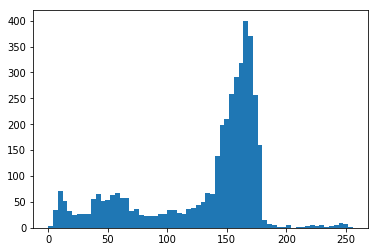

r: 


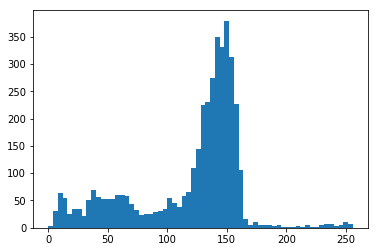

In [11]:
color = ('b', 'g', 'r')
for channel, col in enumerate(color):
    print(f"{col}: ")
    plt.hist(x=resized_train_imgs[0][:, :, channel].ravel(), bins=64, range=[0, 256]);
    plt.show()

In [12]:
# Ref.: https://github.com/Ixiaohuihuihui/Extract-color-histogram-feature/blob/master/rgb_feature.py
# extract rgb features

def ExtractColorHistFeatures(image):
    features = []
    for channel in range(3):
        hist = cv2.calcHist(images=[image], channels=[channel], mask=None, histSize=[64], ranges=[0,256])
        hist = cv2.normalize(hist, hist)
        # features.extend(hist)
        features.append(hist)
    return features

with mp.Pool(processes=NUM_PROCESSES) as pool:
    ### tqdm returns an iterator
    # train_features = pool.map(ExtractFeatures, tqdm(resized_train_imgs))
    # val_features = pool.map(ExtractFeatures, tqdm(resized_val_imgs))
    # test_features = pool.map(ExtractFeatures, tqdm(resized_test_imgs))
    train_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_train_imgs), total=len(resized_train_imgs)))
    val_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_val_imgs), total=len(resized_val_imgs)))
    test_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_test_imgs), total=len(resized_test_imgs)))

100%|██████████| 450/450 [00:00<00:00, 4160.47it/s]


In [13]:
# flatten and reshape the features into (n_samples, n_features)
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

def FlattenFeatures(feature):
    return feature.flatten()

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = np.array(pool.map(FlattenFeatures, tqdm(train_features)))
    val_features = np.array(pool.map(FlattenFeatures, tqdm(val_features)))
    test_features = np.array(pool.map(FlattenFeatures, tqdm(test_features)))

100%|██████████| 450/450 [00:00<00:00, 71806.61it/s]


### Apply XGBoost to verify the performance

In [14]:
def ComputeTop1Acc(y_logit, y):
    return np.mean(y_logit == y)

In [15]:
def ComputeTop5Acc(y_logit, y):
    if type(y_logit) != torch.float64:
        y_logit = torch.tensor(y_logit, dtype=torch.float64)
    if type(y) != torch.float64:
        y = torch.tensor(y, dtype=torch.float64)
        
    y_prob = softmax(y_logit, dim=1)
    y_pred_top5 = y_prob.argsort(axis=1)[:, -5:]
    y_true_in_top5 = [y[i] in y_pred_top5[i] for i in range(len(y))]
    
    return (sum(np.array(y_true_in_top5) == np.array([True]*len(y))) / len(y))

In [16]:
## Xgboost
# train the XGBoost model
# dtrain = xgb.DMatrix(train_features, train_label)
# dval = xgb.DMatrix(val_features, val_label)
# dtest = xgb.DMatrix(test_features, test_label)

# params = {
#     'objective': 'multi:softmax',
#     'eval_metric': 'mlogloss',
#     'num_class': 50,
#     'max_depth': 12,
#     'eta': 0.3,
#     'nthread': 8
# }
# num_round = 10

# model = xgb.train(
#     params=params, 
#     dtrain=dtrain, 
#     num_boost_round=num_round
# )

# Set XGBClassifier parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 50,
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}

# Create an instance of XGBClassifier
model = xgb.XGBClassifier(**params)

# Train the model on the training set
model.fit(train_features, train_label)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=64, num_class=50, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
# Make predictions on the training set
y_pred = model.predict(train_features)
y_pred_proba = model.predict_proba(train_features)

# Evaluate the accuracy of the model
Top1accuracy = ComputeTop1Acc(y_pred, train_label)
Top5accuracy = ComputeTop5Acc(y_pred_proba, train_label)
print("Top-1 accuracy:", Top1accuracy)
print("Top-5 accuracy:", Top5accuracy)

Top-1 accuracy: 0.23259376233714962
Top-5 accuracy: 0.527753651796289


In [18]:
# Make predictions on the testing set
y_pred = model.predict(test_features)
y_pred_proba = model.predict_proba(test_features)

# Evaluate the accuracy of the model
Top1accuracy = ComputeTop1Acc(y_pred, test_label)
Top5accuracy = ComputeTop5Acc(y_pred_proba, test_label)
print("Top-1 accuracy:", Top1accuracy)
print("Top-5 accuracy:", Top5accuracy)

Top-1 accuracy: 0.11333333333333333
Top-5 accuracy: 0.3288888888888889


In [ ]:
# pred_train_label = model.predict(dtrain)
# pred_val_label = model.predict(dval)
# pred_test_label = model.predict(dtest)

# top1_acc_train = ComputeTop1Acc(train_label, pred_train_label)
# top1_acc_val = ComputeTop1Acc(val_label, pred_val_label)
# top1_acc_test = ComputeTop1Acc(test_label, pred_test_label)

# top1_acc_train = ComputeTop5Acc(train_label, pred_train_label)
# top1_acc_val = ComputeTop5Acc(val_label, pred_val_label)
# top1_acc_test = ComputeTop5Acc(test_label, pred_test_label)

# print(f"Accuracy of training set: {top1_acc_train:.4f}")
# print(f"Accuracy of validation set: {top1_acc_val:.4f}")
# print(f"Accuracy of testing set: {top1_acc_test:.4f}")

Accuracy of training set: 0.9736
Accuracy of validation set: 0.0867
Accuracy of testing set: 0.0778
